# Time Series Data Analysis on Job Openings In the USA

Job openings in the construction sector are an important indicator of economic health and labor market dynamics in the United States.

With a growing population and evolving infrastructure needs, understanding and forecasting the trend in job openings is essential for effective planning and long-term sustainability.

This analysis aims to model the number of job openings in the construction sector over time and build a forecasting model using time series techniques.

Main steps include:

1.   Graphical analysis
2.   Model the structure of the time series
3.   Estimating the model parameters
4.   Diagnostic testing to evaluate the fitted model

*We begin by loading the data and exploring it through basic visualizations.*

In [2]:
# using python
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#library(readxl)
data <- read_excel("/content/drive/MyDrive/time series project/Job Openings  S C3.xlsx", col_names = TRUE , skip = 10)
colnames(data) <- c("date", "job_openings")
head(data)

date,job_openings
<dttm>,<dbl>
2004-01-01,159
2004-02-01,111
2004-03-01,151
2004-04-01,180
2004-05-01,177
2004-06-01,122


The dataset contains monthly job openings in the U.S. construction sector, starting from January 2004 to March 2024.

It consists of two columns: date and job_openings, representing the date and the number of job openings in thousands, with a total of 243 observations.

The dataset is clean and free of missing values.

Now, let’s construct our indexed time series object based on this data.

In [4]:
data.ts <- ts(data$job_openings, start= c(2004,1), freq=12)

# Graphical analysis
To understand the time series data effectively we use a graph.

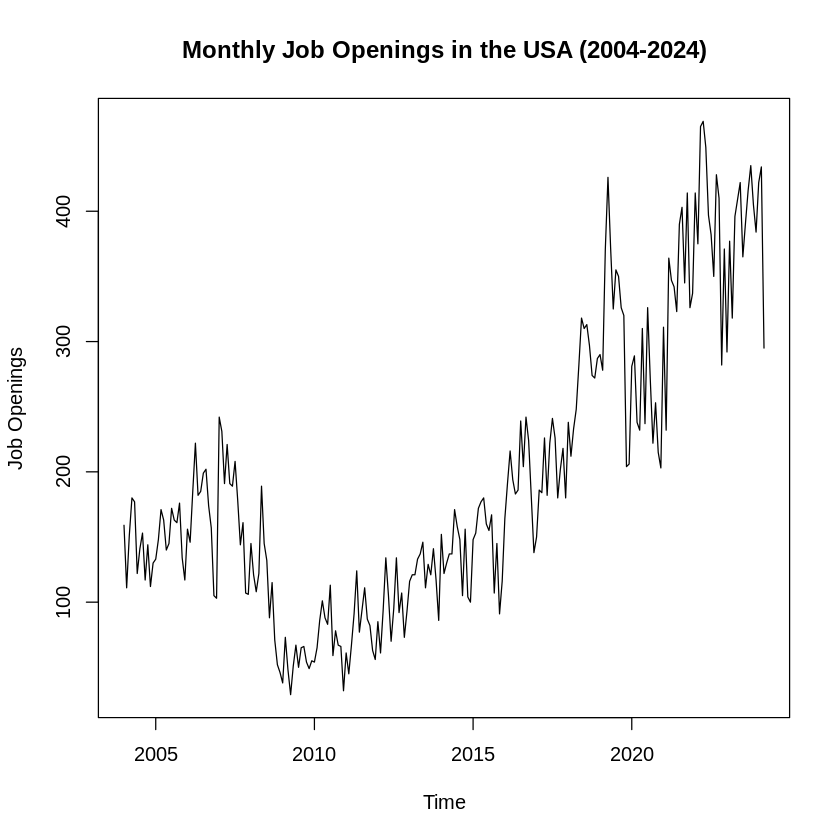

In [5]:
plot(data.ts, main = "Monthly Job Openings in the USA (2004-2024)", ylab="Job Openings")

The plot reveals a trend in job openings within the construction sector, with visible fluctuations over time.

We can see that there are breakpoints in the series, suggesting changes in the underlying data-generating process.

Therefore, we need to account for structural changes when modeling the time series.

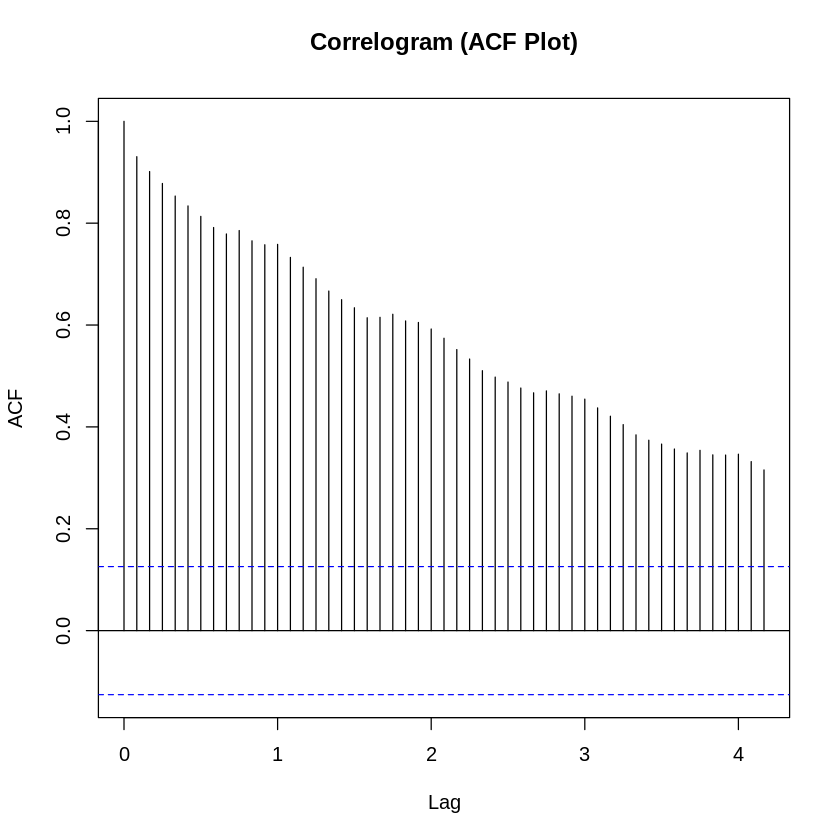

In [6]:
acf(data.ts, main = "Correlogram (ACF Plot)", 50)

The ACF curve shows a slow decay, indicating indeed the presence of a trend in the data.

Additionally, we can observe seasonality, repeating cycles with periodicity = 12 months.

*We will perform both additive and multiplicative decompositions of the time series and evaluate the residuals of each model to determine which type best fits the data for future forecasting.*

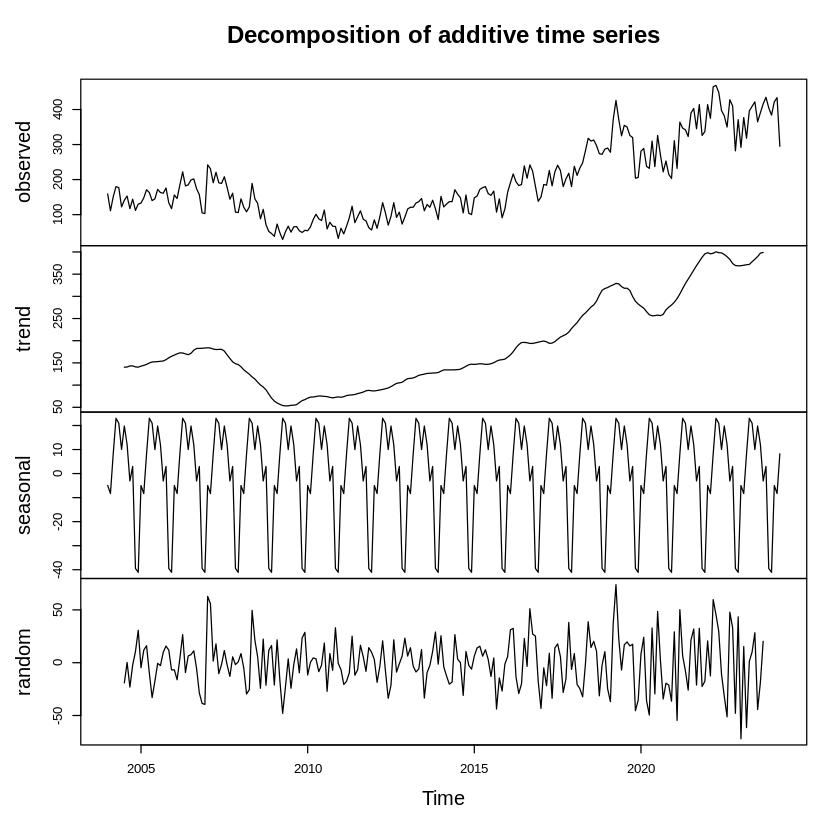

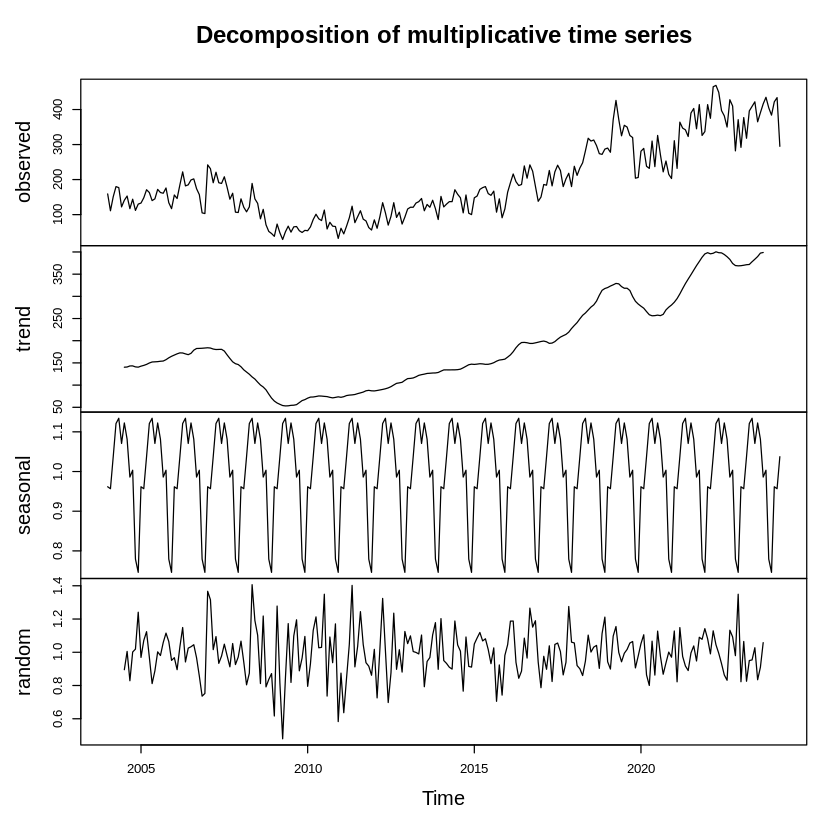

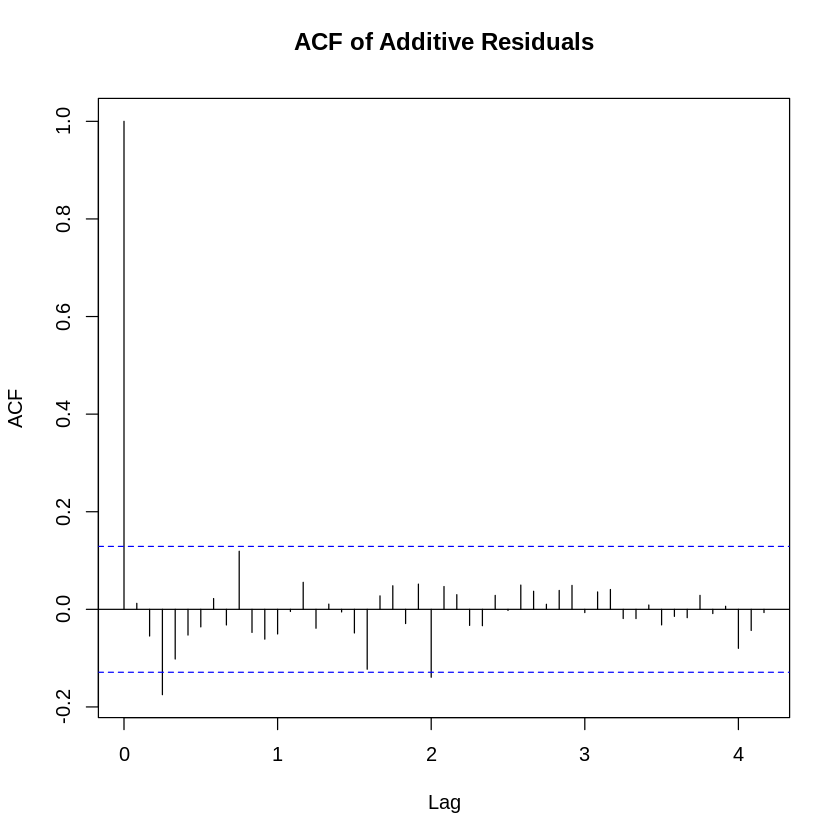

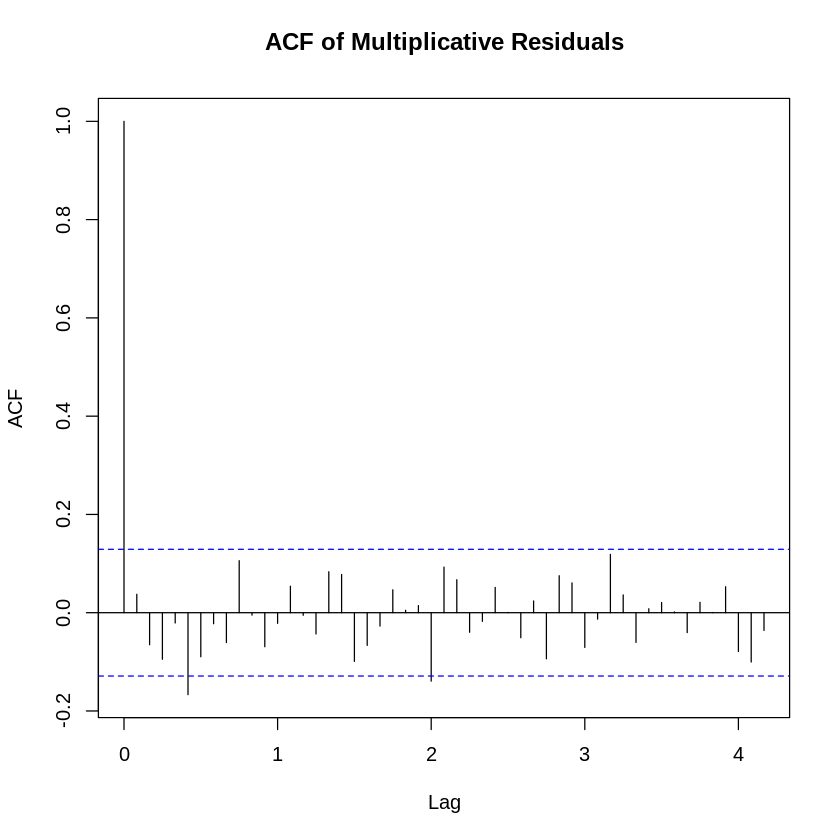

In [7]:
decomp_add <- decompose(data.ts, type = "additive")
plot(decomp_add)

decomp_mult <- decompose(data.ts, type = "multiplicative")
plot(decomp_mult)

acf(na.omit(decomp_add$random), 50, main = "ACF of Additive Residuals")
acf(na.omit(decomp_mult$random), 50, main = "ACF of Multiplicative Residuals")

Both the additive and multiplicative models appear to fit the data well.

However, since the autocorrelation values of the additive model are lower, we will proceed with modeling the time series using the additive model.

# Adjustment of deterministic component of the time series

We will now identify the best model to capture the trend and seasonality in the time series.

1.   **Modeling the trend:** We will build both linear and quadratic models using linear regression with least squares estimation and compare their performance to determine which better captures the underlying trend.

We will also account for structural breaks in the data by using the strucchange library, which allows us to incorporate breakpoints into the model.

*Remark: Before modeling, we will standardize the time variable to ensure that the model emphasizes the patterns in the data rather than being influenced by the scale of the time variable.*

In [8]:
tps <- 1:length(data.ts)

ntps <- (tps - mean(tps)) / sd(tps)

In [9]:
install.packages("strucchange")
library(strucchange)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘sandwich’


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich



*   **Linear model:** Yₜ = a × t + b + εₜ

with coefficients (a and b) that may change at specific time points, corresponding to structural breakpoints in the time series.

Let's first of all identify the breakpoints.

In [10]:
p.break <- breakpoints(data.ts~ntps)
p.break


	 Optimal 5-segment partition: 

Call:
breakpoints.formula(formula = data.ts ~ ntps)

Breakpoints at observation number:
36 72 170 206 

Corresponding to breakdates:
2006(12) 2009(12) 2018(2) 2021(2) 

The optimal trend representation corresponds to a 5-segment partition.

The identified breakpoints occur in December 2006, December 2009, February 2018, and February 2021.

These breakpoints mark significant structural changes in the time series.

In [11]:
l1 <- lm(data.ts ~ breakfactor(p.break) * ntps)

We use display detailed information about the linear regression model of the trend.

In [12]:
summary(l1)


Call:
lm(formula = data.ts ~ breakfactor(p.break) * ntps)

Residuals:
     Min       1Q   Median       3Q      Max 
-101.565  -21.918    0.119   22.095  133.301 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        226.161     58.704   3.853 0.000151 ***
breakfactor(p.break)segment2      -474.935     70.226  -6.763 1.08e-10 ***
breakfactor(p.break)segment3       -91.974     58.812  -1.564 0.119207    
breakfactor(p.break)segment4       166.113     69.922   2.376 0.018326 *  
breakfactor(p.break)segment5        89.420     81.190   1.101 0.271872    
ntps                                49.159     39.670   1.239 0.216515    
breakfactor(p.break)segment2:ntps -428.213     56.102  -7.633 5.87e-13 ***
breakfactor(p.break)segment3:ntps   63.274     40.641   1.557 0.120848    
breakfactor(p.break)segment4:ntps -162.052     56.102  -2.889 0.004235 ** 
breakfactor(p.break)segment5:ntps   -3.648     54.983  -0.066 0.947163  

The linear model has a strong R-squared value of 0.8995, indicating that approximately 89% of the variability in production is explained by the trend.

The p-values for most coefficients are < 0.05, indicating that they are statistically significant. Specifically, the breakpoints for segment 2, segment 4, and the interaction terms involving ntps and the breakpoints are highly significant (p < 0.05).

However, segment 3 and segment 5, as well as the ntps coefficient, show p-values > 0.05, suggesting that these variables may not significantly contribute to the model.

The F-statistic also yields a p-value < 0.05, confirming that the model is globally significant.

Overall, the model provides a good fit to the data.

*   **Quadratic model:** Yₜ = c × t² + a × t + b + εₜ

with coefficients (a, b and c) that may change at specific time points, corresponding to structural breakpoints in the time series.

Let's first of all identify the breakpoints.

In [13]:
p2.break <- breakpoints(data.ts~ntps+I(ntps^2), h=10)
p2.break


	 Optimal 5-segment partition: 

Call:
breakpoints.formula(formula = data.ts ~ ntps + I(ntps^2), h = 10)

Breakpoints at observation number:
57 182 200 226 

Corresponding to breakdates:
2008(9) 2019(2) 2020(8) 2022(10) 

The optimal trend representation corresponds to a 5-segment partition.

The identified breakpoints occur in September 2008, February 2019, August 2020, and October 2022.

These breakpoints mark significant structural changes in the time series.

In [14]:
l2 <- lm(data.ts ~ breakfactor(p2.break)*(ntps+ I(ntps^2)))

We use display detailed information about the new linear regression model of the trend.

In [15]:
summary(l2)


Call:
lm(formula = data.ts ~ breakfactor(p2.break) * (ntps + I(ntps^2)))

Residuals:
    Min      1Q  Median      3Q     Max 
-79.053 -21.293   1.977  22.589  73.243 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                               -375.34     147.77  -2.540 0.011749
breakfactor(p2.break)segment2              501.07     147.83   3.390 0.000825
breakfactor(p2.break)segment3             6598.19    1512.43   4.363 1.95e-05
breakfactor(p2.break)segment4            -4118.20    1046.02  -3.937 0.000110
breakfactor(p2.break)segment5           -15653.06    4607.16  -3.398 0.000802
ntps                                      -828.89     228.20  -3.632 0.000347
I(ntps^2)                                 -313.37      85.97  -3.645 0.000331
breakfactor(p2.break)segment2:ntps         958.85     228.27   4.201 3.82e-05
breakfactor(p2.break)segment3:ntps      -10678.29    3065.10  -3.484 0.000593
breakfactor(p2.break)segment4:ntps   

The linear model has a strong R-squared value of 0.9197, indicating that approximately 91% of the variability in production is explained by the quadratic trend.

The p-values for all coefficients are < 0.05, indicating that they are statistically significant.

The F-statistic also yields a p-value < 0.05, confirming that the model is globally significant.

Overall, the model provides a good fit to the data.

Let's plot both trends: the red line represents the linear model, while the blue line represents the quadratic model.

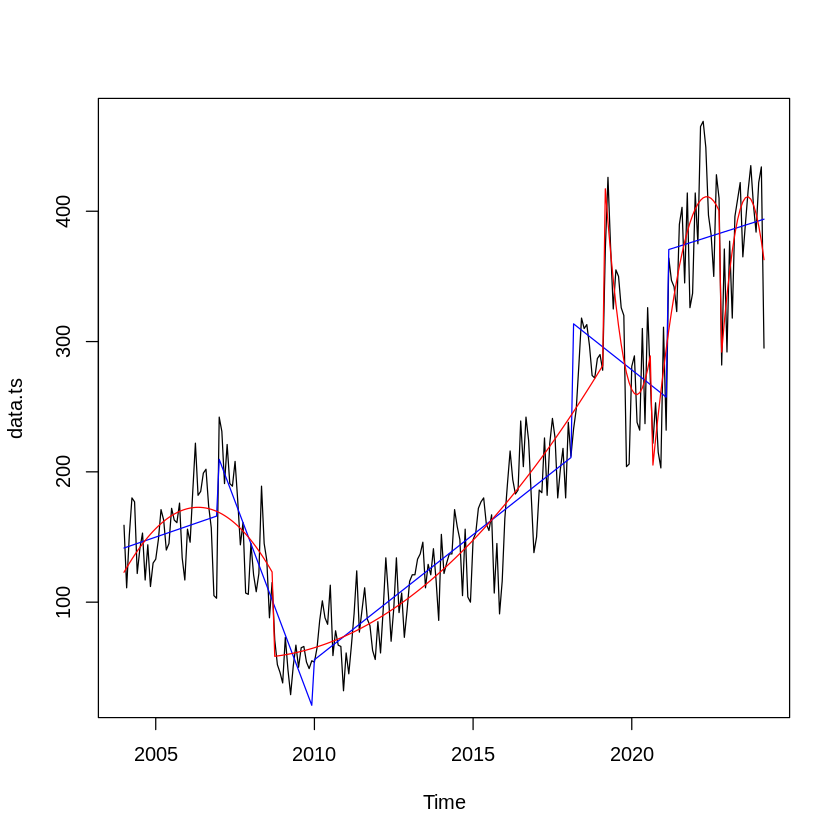

In [16]:
plot(data.ts)
points(time(data.ts), fitted(l1), type="l", col="blue")
points(time(data.ts), fitted(l2), type="l", col="red")

*Since both models are good, we will choose the one with the highest R-squared, which corresponds to the quadratic model for trend modeling.*

Next, we will analyze the correlation of the residuals to assess the quality of the model.

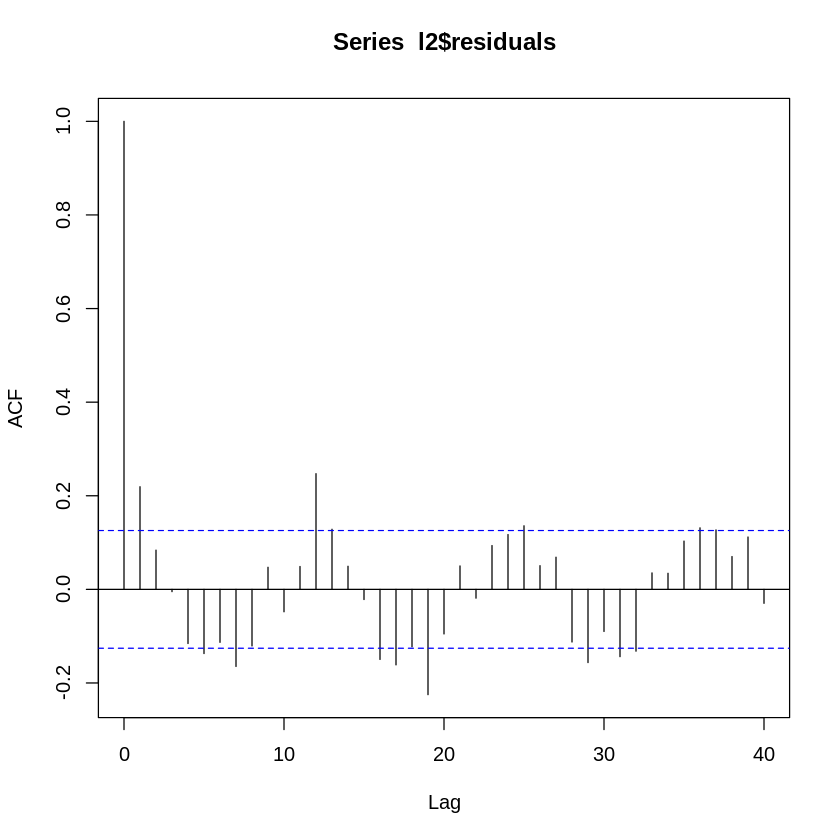

In [17]:
acf(l2$residuals, 40)

The correlogram of the residuals shows a fast decay of autocorrelations, indicating that the trend has been effectively removed from the data.

The model appears to have captured the trend, leaving only the seasonal component with periodicity = 12.

2.   **Model the seasonality**: We will use harmonic functions by adding sine and cosine components to the model, accounting for periodic patterns that repeat at regular intervals. Of course we will use the identified breakpoints to account for the structural change.




In [18]:
MC <- matrix(0, length(data.ts), 6)
MS <- matrix(0, length(data.ts), 6)
for(i in 1:6) MC[,i] <- cos(2*pi*tps/ (12/i))
for(i in 1:6) MS[,i] <- sin(2*pi*tps/ (12/i))

In [19]:
l3 <- lm(data.ts ~ breakfactor(p2.break)*(ntps+ I(ntps^2)) + MC + MS)
summary(l3)


Call:
lm(formula = data.ts ~ breakfactor(p2.break) * (ntps + I(ntps^2)) + 
    MC + MS)

Residuals:
    Min      1Q  Median      3Q     Max 
-87.082 -17.346   0.356  18.735  69.022 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                             -4.474e+02  1.287e+02  -3.475 0.000617
breakfactor(p2.break)segment2            5.724e+02  1.288e+02   4.445 1.41e-05
breakfactor(p2.break)segment3            5.233e+03  1.336e+03   3.918 0.000120
breakfactor(p2.break)segment4           -3.944e+03  9.214e+02  -4.280 2.81e-05
breakfactor(p2.break)segment5           -9.678e+03  4.095e+03  -2.363 0.018999
ntps                                    -9.398e+02  1.988e+02  -4.727 4.11e-06
I(ntps^2)                               -3.553e+02  7.490e+01  -4.744 3.81e-06
MC1                                     -1.828e+01  2.620e+00  -6.977 3.63e-11
MC2                                     -7.010e+00  2.521e+00  -2.781 0.005904
MC3         

When we display the information of the new model, we observe that the p-values of the coefficients MC3, MC5, MC6, MS1, MS2, MS5 and MS6 are > 0.05, indicating that they are not significant.

Therefore, we will exclude these terms from the model.

In [20]:
l4 <- lm(data.ts ~ breakfactor(p2.break)*(ntps+ I(ntps^2)) + MC[ , -c(3, 5, 6)]+ MS[ , -c(1, 2, 5, 6)])
summary(l4)


Call:
lm(formula = data.ts ~ breakfactor(p2.break) * (ntps + I(ntps^2)) + 
    MC[, -c(3, 5, 6)] + MS[, -c(1, 2, 5, 6)])

Residuals:
    Min      1Q  Median      3Q     Max 
-83.754 -16.667  -0.063  19.126  75.637 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                              -442.138    128.479  -3.441 0.000691
breakfactor(p2.break)segment2             567.056    128.525   4.412 1.59e-05
breakfactor(p2.break)segment3            5262.081   1329.619   3.958 0.000102
breakfactor(p2.break)segment4           -4055.373    911.256  -4.450 1.35e-05
breakfactor(p2.break)segment5           -9343.532   4068.341  -2.297 0.022567
ntps                                     -929.702    198.374  -4.687 4.83e-06
I(ntps^2)                                -350.790     74.726  -4.694 4.67e-06
MC[, -c(3, 5, 6)]1                        -18.192      2.618  -6.950 3.98e-11
MC[, -c(3, 5, 6)]2                         -6.918      2.517  -2.74

The model that adjusts for both trend and seasonality has a high R-squared value of 0.9409, indicating that approximately 94% of the variability in production is explained by the trend.

The p-values for the coefficients are < 0.05, indicating that all coefficients are statistically significant.

The F-statistic also yields a p-value < 0.05, confirming that the model is globally significant.

Overall, the model provides a great fit to the data.

*Let's visualize the fitted model in blue alongside the original data.*

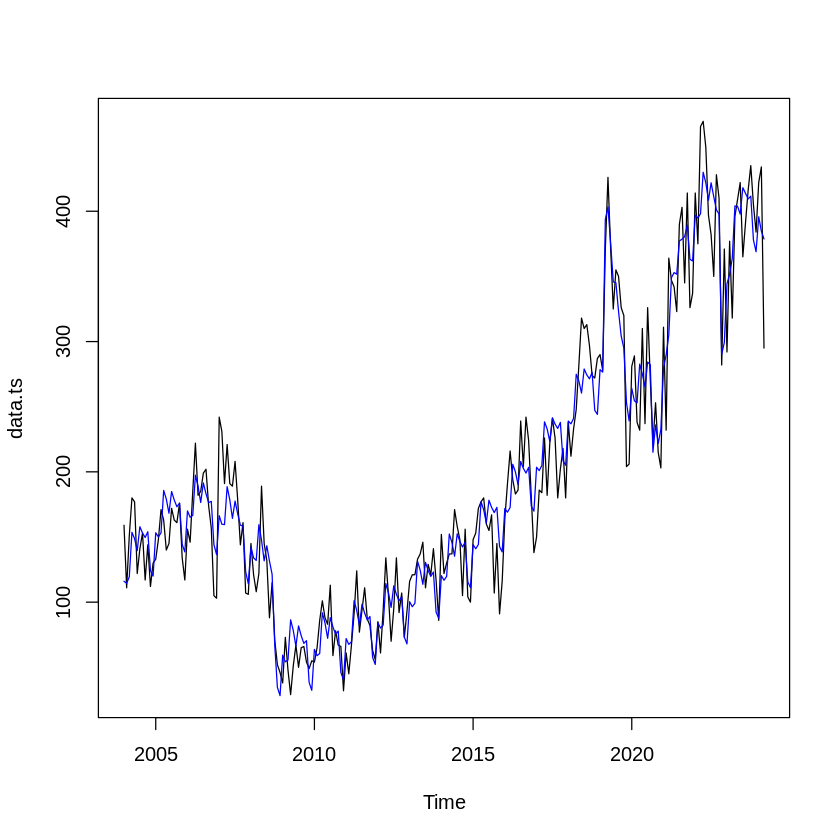

In [21]:
plot(data.ts)
points(time(data.ts), fitted(l4), type = "l", col="blue")

# Test of stationnarity and interpretation


Next, we will analyze the correlation of the residuals to assess the quality of the new model.

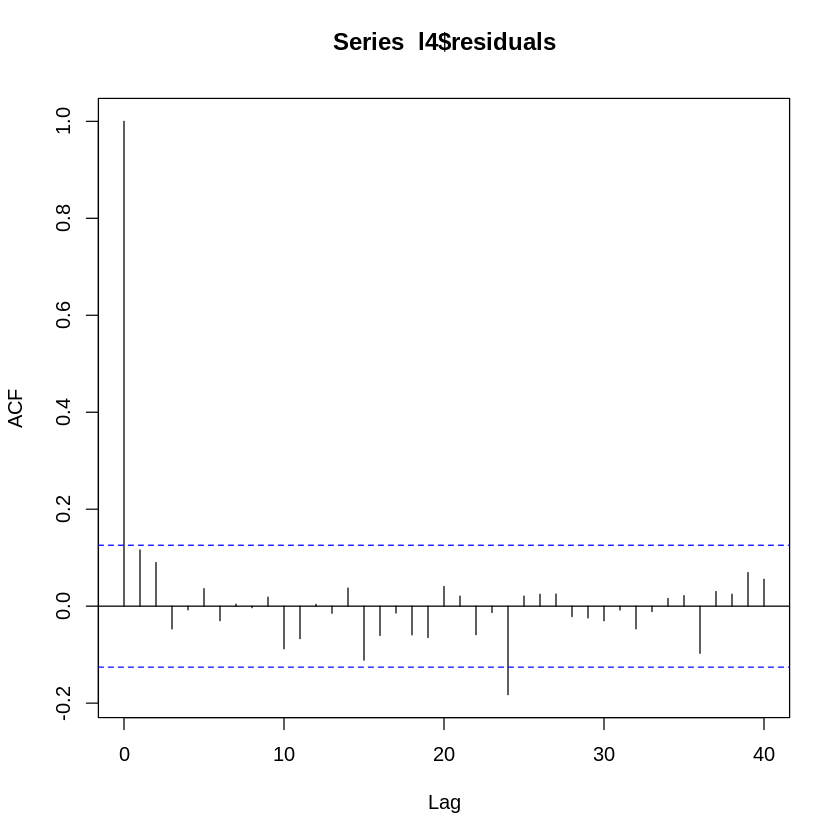

In [22]:
acf(l4$residuals, 40)

Based on the correlogram of the residuals, there is no significant autocorrelation, indicating that the residuals behave like white noise.

*  **Graphically:**

We will plot the histogram, the Q-Q plot, and the time series of the residuals to visually assess whether they resemble white noise (meaning residuals are normally distributed with constant variance and no autocorrelation).

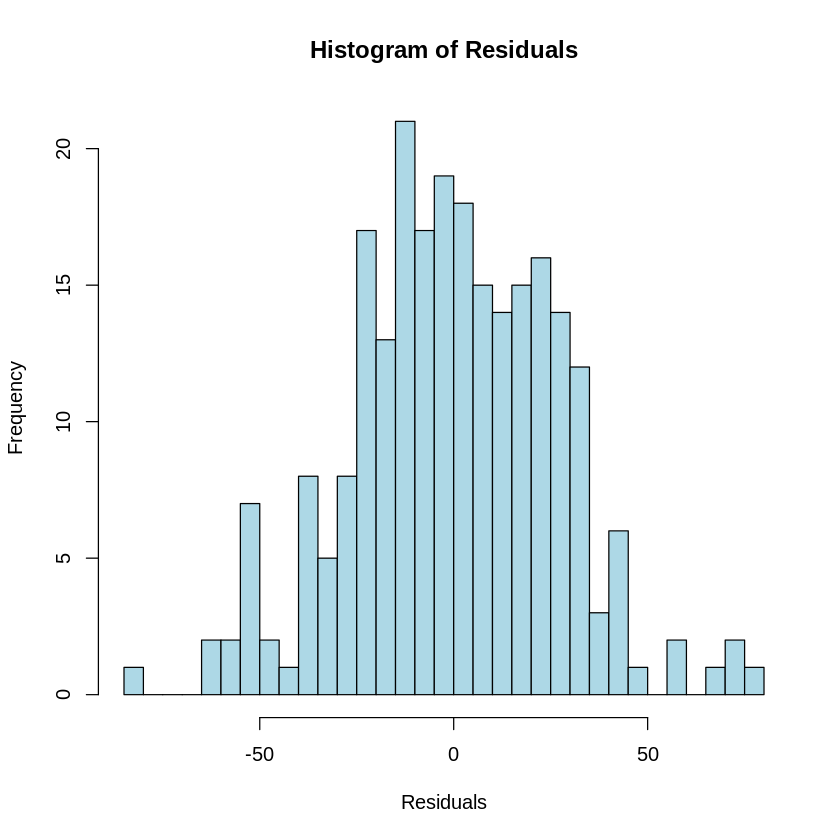

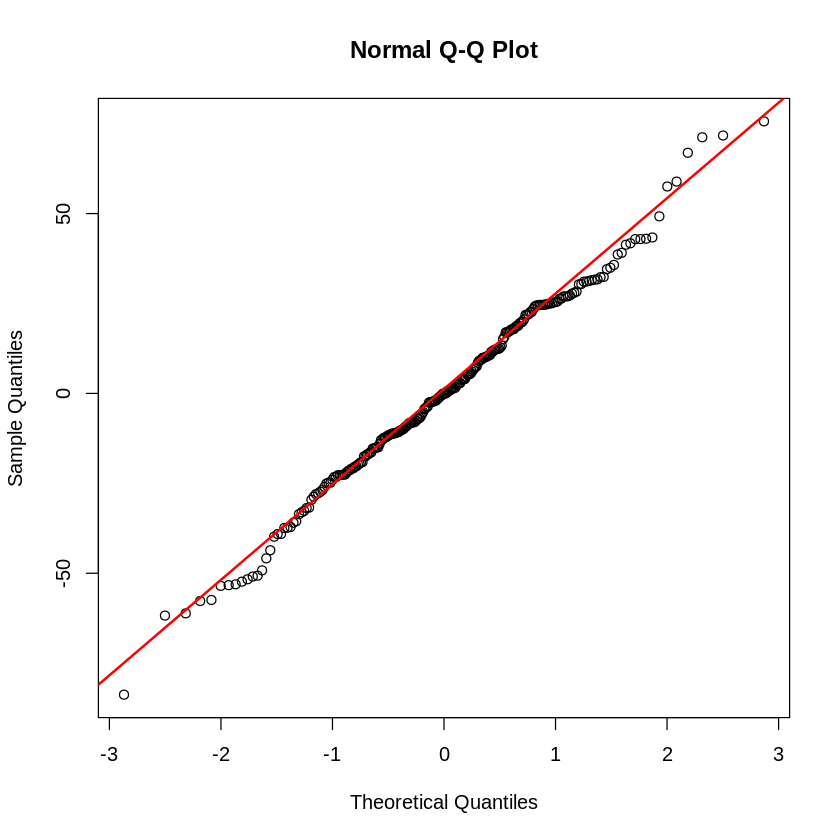

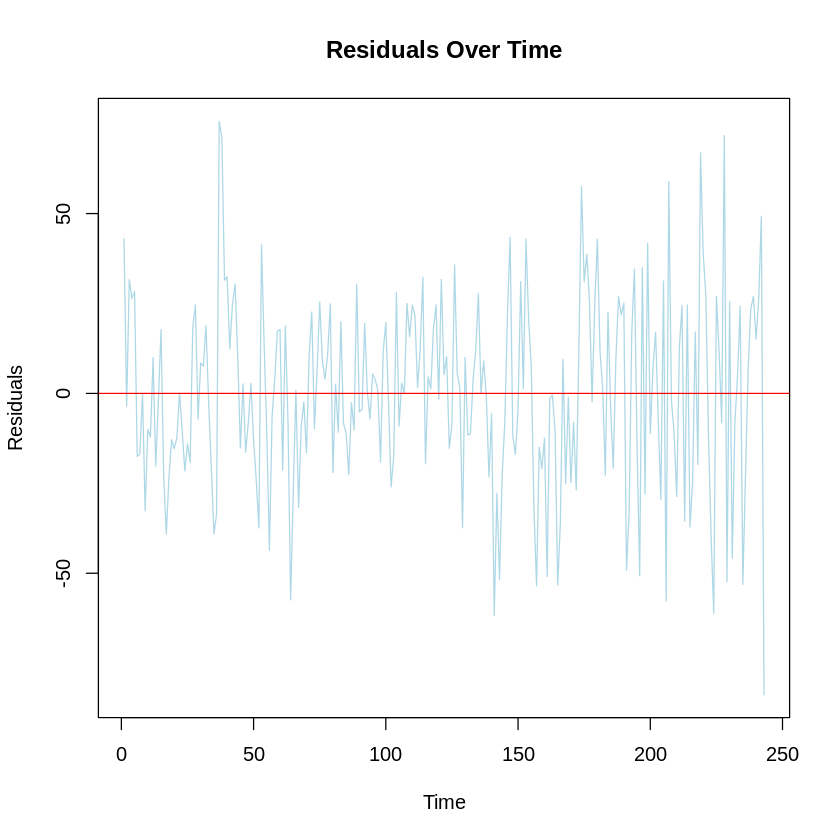

In [23]:
hist(l4$residuals, breaks = 30, main = "Histogram of Residuals", xlab = "Residuals", col = "lightblue")

qqnorm(l4$residuals)
qqline(l4$residuals, col = "red", lwd = 2)

plot.ts(l4$residuals, main = "Residuals Over Time", ylab = "Residuals", col = "lightblue")
abline(h = 0, col = "red")


Based on the visual inspection of the residuals, we conclude that they behave like white noise, indicating a good model fit.

*   **Statistically:**

To complement the graphical analysis, we now proceed with statistical test to verify whether the residuals meet the assumptions of normality and randomness.

We will use the Shapiro-Wilk test, with the following hypotheses:
*   H₀: The data follow a normal distribution.
*   H₁: The data do not follow a normal distribution.

In [24]:
shapiro.test(l4$residuals)


	Shapiro-Wilk normality test

data:  l4$residuals
W = 0.99341, p-value = 0.3612


Based on statistical testing using the **Shapiro-Wilk test**, the p-value is > 0.05, indicating that we fail to reject the null hypothesis.

Therefore, we conclude that the residuals follow a normal distribution.

We will also perform Box Pierce test to see if we have any autocorrelation left in the residuals.

The hypotheses of the test are:
*   H₀: No autocorrelation between the residuals.
*   H₁: There is still autocorrelation left in the residuals.

In [25]:
Box.test(l4$residuals)


	Box-Pierce test

data:  l4$residuals
X-squared = 3.2642, df = 1, p-value = 0.07081


Based on the test, we got a p_vale > 0.05, so we will accept H0. Therefore we don't have any additional information left in the residuals to model.

So now let's do a stationary test using Augmented Dickey-Fuller to verify that indeed the residuals are stationnary.

In [27]:
#install.packages("tseries")
#library(tseries)
adf.test(l4$residuals)

Warning message in adf.test(l4$residuals):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  l4$residuals
Dickey-Fuller = -5.6404, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


The test gave us p_value < 0.05 so we accept H0: the residuals are indeed stationary.

# Construction of the Arima Model

After evaluating the residuals of the final adjusted model, there isn't any information left so we won't need to construct an Arima model.

# Conclusion

Our work indicates that the model has successfully captured the underlying structure of the data, with no significant patterns left in the residuals.

Overall, the final model (l4) provides an excellent fit.

In conclusion, we can confidently use this final model, incorporating trend, seasonality, and structural breakpoints to forecast future values.